# Multi-Class Classification using Logistic Regression

This notebook is an implementation of Multi-Class classification using Logistic Regression to
recognize handwritten digits (from 0 to 9). Automated handwritten digit
recognition is widely used today, from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This
notebook will show how these classifications are implemented.

In [1]:
# Import the necessary packages
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from scipy.io import loadmat
from scipy.optimize import minimize

%matplotlib inline

We have a data set in 'data1.mat' that contains 5000 training examples of handwritten digits. Our data file is in a format native to MATLAB and not automatically recognizable by pandas, so to load it in Python we need to use a SciPy utility loadmat which creates a dictionary.

In [2]:
# Load the dataset
dataset = loadmat('data1.mat')  
dataset

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

The dictionary shown above contain the features in 'X' and output in 'y'. Shape of these arrays are shown below:

In [3]:
X = dataset['X']
y = dataset['y']
X.shape, y.shape

((5000, 400), (5000, 1))

There are 5000 training examples, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a  floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is 'unrolled' into a 400-dimensional vector. Each of these training examples becomes a single row in our data
matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

The second part of the training set is a 5000-dimensional vector 'y' that contains labels for the training set. To make things more compatible with indexing, we can map the digit zero to the value ten. Therefore, a '0' digit is labeled as '10', while
the digits '1' to '9' are labeled as '1' to '9' in their natural order.

## Visualizing the data

We begin by visualizing a subset of the training set. The following code randomly selects 100 rows from X and maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together.

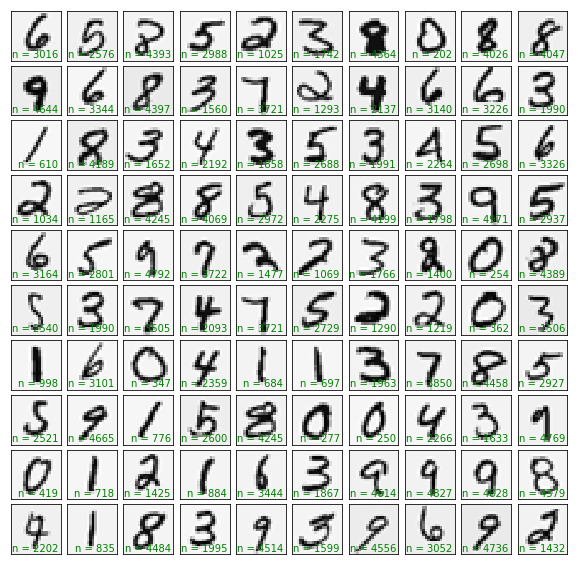

In [4]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    rand_n = np.random.randint(5000)
    im = X[rand_n, :]

    ax.imshow(im.reshape((20, 20), order='F'), cmap='binary')
    ax.text(0.95, 0.05, 'n = {0}'.format(rand_n + 1), ha='right',
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

In [5]:
# Define Sigmoid Function
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

## Vectorizing Logistic Regression

We will be using multiple one-vs-all logistic regression models to build a
multi-class classifier. Since there are 10 classes, we need to train 10
separate logistic regression classifiers. To make this training effcient, it is
important to ensure that our code is well vectorized. In this section, we
will implement a vectorized version of logistic regression that does not employ
any for loops.

### Vectorizing Cost Function



In [6]:
# Define the Regularized Cost function
def costFunctionReg(theta, X, y, lambda_reg):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    regularized = (lambda_reg / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    
    J = np.sum(first - second) / (len(X)) + regularized
    return J

### Vectorizing the Gradient



In [7]:
def gradientReg(theta, X, y, lambda_reg):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y

    # Vectorized implementation of gradient calculation
    grad = ((X.T * error) / len(X)).T + ((lambda_reg / len(X)) * theta)

    # Intercept gradient is not regularized
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X)

    return np.array(grad).ravel()

## One-vs-All Classifier

Now we will implement one-vs-all classification by
training multiple regularized logistic regression classifiers, one for each of
the 'K' classes in our dataset. In this handwritten digits dataset,
K = 10, but we will make our code work for any value of K.

We will now complete the code to train one classifier for
each class. In particular, our code should return all the classifier parameters
in a matrix ** $\Theta \in  R^{K x (N+1)} $ **, where each row of $\Theta$ corresponds to the learned
logistic regression parameters for one class. We can do this with a 'for'-loop
from 1 to K, training each classifier independently.
Note that the 'y' argument to this function is a vector of labels from 1 to
10, where we have mapped the digit '0' to the label 10.

When training the classifier for class k $\in$ {1, ...,K}, we want a m-dimensional vector of labels 'y', where $y_j$ $\in$ {0, 1} indicates whether the j-th
training instance belongs to class k ($y_j$ = 1), or if it belongs to a different
class ($y_j$ = 0).

In [8]:
def one_vs_all(X, y, num_labels, lambda_reg):  
    rows = X.shape[0]
    params = X.shape[1]

    all_theta = np.zeros((num_labels, params + 1))

    # Insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)

    # Labels are 1-indexed instead of 0-indexed, to match the dataset
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))

        # minimize the objective function
        fmin = minimize(fun=costFunctionReg, x0=theta, args=(X, y_i, lambda_reg), method='TNC', jac=gradientReg)
        all_theta[i-1,:] = fmin.x

    return all_theta

A few things to note here. First, we're adding an extra parameter to theta (along with a column of ones to the training data) to account for the intercept term. Second, we're transforming y from a class label to a binary value for each classifier (either "is class i" or "is not class i"). Finally, we're using SciPy's newer optimization API to minimize the cost function for each classifier. The API takes an objective function, an initial set of parameters, an optimization method, and a gradient function. The parameters found by the optimization routine are then assigned to the parameter array.

In [9]:
all_theta = one_vs_all(X, y, 10, 0.1)  
all_theta

array([[ -5.92145692e-04,   0.00000000e+00,   0.00000000e+00, ...,
         -3.59744654e-09,   3.71183944e-10,   0.00000000e+00],
       [ -7.17080473e-04,   0.00000000e+00,   0.00000000e+00, ...,
          5.81217735e-08,  -4.96248370e-09,   0.00000000e+00],
       [ -6.71691751e-04,   0.00000000e+00,   0.00000000e+00, ...,
         -6.09592778e-09,   3.72049769e-10,   0.00000000e+00],
       ..., 
       [ -5.60873022e-04,   0.00000000e+00,   0.00000000e+00, ...,
         -5.53997763e-09,   3.43612329e-10,   0.00000000e+00],
       [ -6.12165983e-04,   0.00000000e+00,   0.00000000e+00, ...,
         -6.47861572e-09,   4.24991029e-10,   0.00000000e+00],
       [ -1.06139604e-03,   0.00000000e+00,   0.00000000e+00, ...,
         -5.60096576e-08,   1.82034745e-09,   0.00000000e+00]])

## One-vs-All Prediction

After training the one-vs-all classifier, we can now use it to predict the
digit contained in a given image. For each input, we will compute the
'probability' that it belongs to each class using the trained logistic regression
classifiers. The one-vs-all prediction function will pick the class for which the
corresponding logistic regression classifier outputs the highest probability and
return the class label (1, 2,..., or K) as the prediction for the input example.

In [10]:
def predict_all(X, all_theta):  
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]

    # Insert ones to match the shape
    X = np.insert(X, 0, values=np.ones(rows), axis=1)

    X = np.matrix(X)
    all_theta = np.matrix(all_theta)

    # Compute the class probabilities
    h = sigmoid(X * all_theta.T)

    # Create an array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)

    # Add one for the true label prediction since our array was zero-indexed
    h_argmax = h_argmax + 1

    return h_argmax

In [11]:
prediction = predict_all(X, all_theta)  
correct = [1 if a == b else 0 for (a, b) in zip(prediction, y)]  
accuracy = (sum(map(int, correct)) / float(len(correct)))  
print('Classifier Accuracy is {0}%'.format(accuracy * 100))

Classifier Accuracy is 76.6%
